<a href="https://colab.research.google.com/github/AbhyudayPuri/Prediction_Vehicle_Speed_From_DashCam/blob/master/Vehicle_Dash_Cam_Speed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vehicle Dash Cam Speed Prediction

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
import cv2 as cv
import os
import matplotlib.pyplot as plt
from google.colab import files

In [0]:
labels = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/SpeedChallengeData/data/train.txt", sep=" ", header=None)
labels.columns=['Speed']
labels.head()

,Speed
0,28.105569
1,28.105569
2,28.106527
3,28.130404
4,28.109243


In [0]:
# Reading the train video
vidcap = cv.VideoCapture('/content/gdrive/My Drive/Colab Notebooks/SpeedChallengeData/data/train.mp4')
success,image = vidcap.read()
count = 0
while success:
  cv.imwrite("/content/train/frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  # print('Read a new frame: ', success)
  count += 1

In [0]:
# Adding the file names to the label dataframe
fname = os.listdir("/content/gdrive/My Drive/Colab Notebooks/SpeedChallengeData/data/train/")
labels.insert(0, "Frame0", fname)
labels.head()

,Frame0,Speed
0,frame0.jpg,28.105569
1,frame1.jpg,28.105569
2,frame2.jpg,28.106527
3,frame3.jpg,28.130404
4,frame4.jpg,28.109243


Text(0, 0.5, 'Speed')

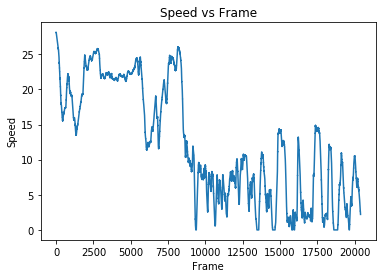

In [0]:
# Visualizing the Speed
plt.plot(labels["Speed"])
plt.title("Speed vs Frame")
plt.xlabel("Frame")
plt.ylabel("Speed")

In [0]:
fname1 = fname[1:]
fname1.append("frame20400.jpg")
labels.insert(1, "Frame1", fname1)
labels.head()

,Frame0,Frame1,Speed
0,frame0.jpg,frame1.jpg,28.105569
1,frame1.jpg,frame2.jpg,28.105569
2,frame2.jpg,frame3.jpg,28.106527
3,frame3.jpg,frame4.jpg,28.130404
4,frame4.jpg,frame5.jpg,28.109243


In [0]:
labels.tail()

,Frame0,Frame1,Speed
20395,frame20395.jpg,frame20396.jpg,2.329180
20396,frame20396.jpg,frame20397.jpg,2.289795
20397,frame20397.jpg,frame20398.jpg,2.292917
20398,frame20398.jpg,frame20399.jpg,2.260600
20399,frame20399.jpg,frame20400.jpg,2.206759


In [0]:
# Deleting the last row
labels.drop(labels.tail(1).index,inplace=True) # drop last row
labels.tail()

,Frame0,Frame1,Speed
20394,frame20394.jpg,frame20395.jpg,2.364811
20395,frame20395.jpg,frame20396.jpg,2.329180
20396,frame20396.jpg,frame20397.jpg,2.289795
20397,frame20397.jpg,frame20398.jpg,2.292917
20398,frame20398.jpg,frame20399.jpg,2.260600


In [0]:
# Saving the dataframe
labels.to_csv("/content/gdrive/My Drive/Colab Notebooks/SpeedChallengeData/data/labels.csv")

In [0]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [0]:
# Read the labels dataframe
labels = pd.read_csv("/content/labels.csv")
labels.drop(columns=["Unnamed: 0"], inplace=True)
labels.head()

,Frame0,Frame1,Speed
0,frame0.jpg,frame1.jpg,28.105569
1,frame1.jpg,frame2.jpg,28.105569
2,frame2.jpg,frame3.jpg,28.106527
3,frame3.jpg,frame4.jpg,28.130404
4,frame4.jpg,frame5.jpg,28.109243


In [0]:
from sklearn.model_selection import train_test_split

# Splitting the dataset
train, val = train_test_split(labels, test_size=0.2)

In [0]:
class CustomDatasetFromCSV(Dataset):
    # def __init__(self, csv_path, height, width, transform=None):
    def __init__(self, csv_df, img_dir, transform=None):    
        self.data = csv_df
        self.img_dir = img_dir
        self.labels = np.asarray(self.data.iloc[:, -1])
        # self.height = height
        # self.width = width
        self.transform = transform

    def __getitem__(self, index):
        speed = self.labels[index]
        img1 = cv2.imread(os.path.join(self.img_dir, self.data.iloc[index,0]))
        img2 = cv2.imread(os.path.join(self.img_dir, self.data.iloc[index,1]))
        img = {"img1" : img1, "img2" : img2, "flow": None}
        # Transform image to tensor
        if self.transform is not None:
            img = self.transform(img)
            img1 = img["img1"]
            flow = img["flow"]
        # Return image and the label
        return (img1, flow, speed)

    def __len__(self):
        return len(self.data.index)

In [0]:
class BGR2RGB(object):
    def __call__(self, img):
        img1 = img["img1"]
        img2 = img["img2"]
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        img1 = cv2.normalize(img1, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        img2 = cv2.normalize(img2, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        img = {"img1" : img1, "img2" : img2, "flow": None}
        return img
        
class BrightnessPerturb(object):
  def __call__(self, img):
    img1 = img["img1"]
    img2 = img["img2"]
    bright_factor = 0.2 + np.random.uniform()
    hsv1 = cv2.cvtColor(img1, cv2.COLOR_RGB2HSV)
    hsv2 = cv2.cvtColor(img2, cv2.COLOR_RGB2HSV)
    # perform brightness augmentation only on the second channel
    hsv1[:,:,2] = hsv1[:,:,2] * bright_factor
    hsv2[:,:,2] = hsv2[:,:,2] * bright_factor
    
    # change back to RGB
    img = {"img1" : cv2.cvtColor(hsv1, cv2.COLOR_HSV2RGB), "img2" : cv2.cvtColor(hsv2, cv2.COLOR_HSV2RGB), "flow": None}
    return img

class Resize(object):
  def __call__(self, img):
    img1 = img["img1"]
    img2 = img["img2"]
    # Crop out sky (top) (100px) and black right part (-90px)
    img1_crop = img1[100:440, :]
    img2_crop = img2[100:440, :]
    
    img1 = cv2.resize(img1_crop, (220, 66), interpolation = cv2.INTER_AREA)
    img2 = cv2.resize(img2_crop, (220, 66), interpolation = cv2.INTER_AREA)
    
    img = {"img1" : img1, "img2" : img2, "flow": None}
    return img

class OpticalFlow(object):
  def __call__(self, img):
    img1 = img["img1"]
    img2 = img["img2"]

    img1_gray = np.float32(cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY))
    img2_gray = np.float32(cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY))
    
    # hsv = np.zeros((66, 220, 3))
    # # set saturation
    # hsv[:,:,1] = cv2.cvtColor(image_next, cv2.COLOR_RGB2HSV)[:,:,1]
 
    # Flow Parameters
#     flow_mat = cv2.CV_32FC2
    flow_mat = None
    image_scale = 0.5
    nb_images = 1
    win_size = 15
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.3
    extra = 0

    # obtain dense optical flow paramters
    flow = cv2.calcOpticalFlowFarneback(img1_gray, img2_gray,  
                                        flow_mat, 
                                        image_scale, 
                                        nb_images, 
                                        win_size, 
                                        nb_iterations, 
                                        deg_expansion, 
                                        STD, 
                                        0)
    
    flow_mag = np.sqrt(flow[:,:,0]**2 + flow[:,:,1]**2)
    flow_mag = np.expand_dims(flow_mag, axis=0)
    img = {"img1" : img1, "img2" : img2, "flow" : flow_mag}
    return img

class ToTensor(object):
    def __call__(self, img):
        img1 = img["img1"]
        img2 = img["img2"]
        flow = img["flow"]
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        img1 = img1.transpose((2, 0, 1))
        img = {"img1" : torch.from_numpy(img1), "img2" : torch.from_numpy(img2), "flow" : torch.from_numpy(flow)}
        return img

In [0]:
train_dir = "/content/train/"
transform = transforms.Compose([BGR2RGB(), BrightnessPerturb(), Resize(), OpticalFlow(), ToTensor()])
train_dataset = CustomDatasetFromCSV(train, train_dir, transform)

NameError: ignored

In [0]:
val_dir = "/content/train/"
transform = transforms.Compose([BGR2RGB(), BrightnessPerturb(), Resize(), OpticalFlow(), ToTensor()])
val_dataset = CustomDatasetFromCSV(val, val_dir, transform)

In [0]:
train_loader = DataLoader(train_dataset,
                          batch_size=32,
                          shuffle=True,
                          num_workers=4 # 1 for CUDA
                         )

val_loader = DataLoader(val_dataset,
                          batch_size=32,
                          shuffle=True,
                          num_workers=4 # 1 for CUDA
                         )

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(4, 24, 5)
        self.conv2 = nn.Conv2d(24, 36, 5)
        self.conv3 = nn.Conv2d(36, 48, 3)
        self.conv4 = nn.Conv2d(48, 64, 3)
        self.conv5 = nn.Conv2d(64, 64, 3)

        self.fc1 = nn.Linear(64 * 21 * 1, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 10)
        self.fc4 = nn.Linear(10, 1)

        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = self.pool(F.leaky_relu(self.conv3(x)))
        x = F.leaky_relu(self.conv4(x))
        x = F.leaky_relu(self.conv5(x))

        x = x.view(-1, 64 * 21 * 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [0]:
# for batch_idx, (img, flow, speed) in enumerate(train_loader):
#   print(img.shape)
#   print(flow.shape)
#   print(speed)
#   print(batch_idx)
#   break

# print(torch.cuda.is_available())
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda')
print(device)

cuda


In [0]:
net = Net().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5, last_epoch=-1)

In [0]:
num_epochs = 10
train_loss = []
val_loss = []

for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    net.train()

    for i, data in enumerate(train_loader):
      # get the inputs; data is a list of [inputs, labels]
      (img, flow, speed) = data
      # zero the parameter gradients
      optimizer.zero_grad()

      # Concatenating image and flow
      inputs = torch.cat((img, flow), 1).to(device)
      speed = speed.unsqueeze(1)
      speed = speed.to(device)

      # forward + backward + optimize
      outputs = net(inputs)
      loss = criterion(outputs, speed)

      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
      if (i+1) % 50 == 0:    # print every 2000 mini-batches
          print('[%d, %5d] Training loss: %.3f' %
                (epoch + 1, i + 1, running_loss / 50))
          train_loss.append(running_loss)
          running_loss = 0.0

    net.eval()

    running_loss = 0.0
    for i, data in enumerate(val_loader):
      # get the inputs; data is a list of [inputs, labels]
      (img, flow, speed) = data

      # Concatenating image and flow
      inputs = torch.cat((img, flow), 1).to(device)
      speed = speed.unsqueeze(1)
      speed = speed.to(device)

      # forward + backward + optimize
      outputs = net(inputs)
      loss = criterion(outputs, speed)

      running_loss += loss.item()
    
    running_loss = running_loss / 127.0

    val_loss.append(running_loss)

    print("Validation Loss: %.3f" % running_loss)
    
    if((epoch+1) % 2 == 0):
      # checkpoint = {'model': net(),
      #               'state_dict': net.state_dict(),
      #               'optimizer' : optimizer.state_dict()}
      torch.save(net.state_dict(), '/content/model.pt')
      print("The model has been saved")
      # torch.save(checkpoint, '/content/checkpoint.pth')
         
    scheduler.step()

files.download('/content/model.pt') 
print('Finished Training')

[1,    50] Training loss: 121.450
[1,   100] Training loss: 68.834
[1,   150] Training loss: 56.217
[1,   200] Training loss: 49.252
[1,   250] Training loss: 44.190
[1,   300] Training loss: 39.214
[1,   350] Training loss: 34.219
[1,   400] Training loss: 32.422
[1,   450] Training loss: 26.301
[1,   500] Training loss: 24.601
Validation Loss: 20.089
[2,    50] Training loss: 17.803
[2,   100] Training loss: 17.048
[2,   150] Training loss: 19.429
[2,   200] Training loss: 17.655
[2,   250] Training loss: 13.253
[2,   300] Training loss: 12.958
[2,   350] Training loss: 10.487
[2,   400] Training loss: 10.337
[2,   450] Training loss: 9.676
[2,   500] Training loss: 8.140
Validation Loss: 7.903
The model has been saved
[3,    50] Training loss: 6.255
[3,   100] Training loss: 6.235
[3,   150] Training loss: 5.394
[3,   200] Training loss: 5.443
[3,   250] Training loss: 5.103
[3,   300] Training loss: 5.003
[3,   350] Training loss: 5.261
[3,   400] Training loss: 4.414
[3,   450] Tr

In [0]:
train.to_csv("train.csv")
val.to_csv("val.csv")

In [0]:
img_og = img_np.transpose(2,3,1,0)
img_og.shape

(66, 220, 3, 10)

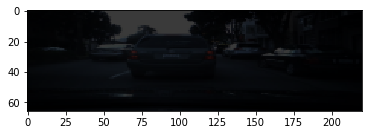

In [0]:
plt.imshow(img_og[:,:,:,0])

In [0]:
flow_og = flow_np.transpose(2,3,1,0)
flow_og.shape

(66, 220, 1, 10)

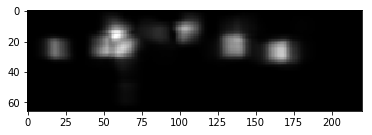

In [0]:
plt.imshow(flow_og[:,:,0,0], cmap="gray")

In [0]:
speed.shape

torch.Size([32])

In [0]:
temp = speed.unsqueeze(1)
temp.shape

torch.Size([32, 1])

In [0]:
torch.save(net, '/content/model.ckpt')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
import cv2 as cv
# Reading the train video
vidcap = cv.VideoCapture('/content/gdrive/My Drive/Colab Notebooks/SpeedChallengeData/data/test.mp4')
success,image = vidcap.read()
count = 0
while success:
  cv.imwrite("/content/test/frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  # print('Read a new frame: ', success)
  count += 1

In [0]:
import os
len(os.listdir("/content/test"))

10798

In [0]:
import pandas as pd

test = pd.DataFrame(columns=['Frame0','Frame1','Speed'])

In [0]:
frame0 = []
frame1 = []
speed = []

for i in range(len(os.listdir("/content/test/"))):
  frame0.append("frame" + str(i) + ".jpg")
  frame1.append("frame" + str(i+1) + ".jpg")
  speed.append(0)

In [0]:
test["Frame0"] = frame0
test["Frame1"] = frame1
test["Speed"] = speed

In [0]:
test.head()

,Frame0,Frame1,Speed,speed
0,frame0.jpg,frame1.jpg,0,0
1,frame1.jpg,frame2.jpg,0,0
2,frame2.jpg,frame3.jpg,0,0
3,frame3.jpg,frame4.jpg,0,0
4,frame4.jpg,frame5.jpg,0,0


In [0]:
test_dir = "/content/test/"
transform = transforms.Compose([BGR2RGB(), BrightnessPerturb(), Resize(), OpticalFlow(), ToTensor()])
test_dataset = CustomDatasetFromCSV(test, test_dir, transform)

test_loader = DataLoader(test_dataset,
                          batch_size=32,
                          shuffle=False,
                          num_workers=4 # 1 for CUDA
                         )

In [0]:
net.load_state_dict(torch.load("/content/model_4.pt"))

<All keys matched successfully>

In [0]:
predict = []
import warnings
warnings.filterwarnings('ignore')
net.eval()
for i, data in enumerate(test_loader):
  # get the inputs; data is a list of [inputs, labels]
  (img, flow, speed) = data

  # Concatenating image and flow
  inputs = torch.cat((img, flow), 1).to(device)
  speed = speed.unsqueeze(1)
  speed = speed.to(device)

  # forward + backward + optimize
  outputs = net(inputs)

  predict.append(outputs.to('cpu').detach().numpy())

error: ignored

In [0]:
numel(predict)

NameError: ignored

In [0]:
flatten = lambda predict: [item for sublist in predict for item in sublist]

In [0]:
import itertools
merged = list(itertools.chain.from_iterable(predict))

In [0]:
len(merged)

10784

In [0]:
len(frame0)

10798

In [0]:
with open('/content/keon.txt', 'r') as f:
    x = f.readlines()

In [0]:
predict_arr = np.array(merged)
keon = np.array(x[0:10784])

In [0]:
predict_arr.shape

(10784, 1)

In [0]:
keon = keon.reshape(-1,1)
keon.shape

(10784, 1)

In [0]:
np.mean((np.float32(predict_arr) - np.float32(keon))**2)

54.76434